<a href="https://www.kaggle.com/code/klyushnik/episode-12?scriptVersionId=168526075" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import pandas_profiling
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib as mpl
mpl.rcParams.update(mpl.rcParamsDefault)
import warnings
warnings.filterwarnings('ignore')
from IPython.display import Image
%matplotlib inline

from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2

from sklearn.model_selection import train_test_split

import os
import catboost
from catboost import *
from catboost import CatBoostClassifier

from catboost.utils import get_roc_curve
import sklearn
from sklearn import metrics

from catboost.utils import get_fpr_curve
from catboost.utils import get_fnr_curve

import shap

from sklearn.model_selection import StratifiedKFold, KFold, StratifiedGroupKFold
from sklearn.model_selection import RepeatedKFold
from sklearn.metrics import log_loss

import optuna

import sklearn.model_selection
import sklearn.svm
import itertools
from sklearn.metrics import classification_report
import pickle
from sklearn.metrics import accuracy_score
import lightgbm as lgb
import xgboost as xgb
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import RepeatedStratifiedKFold
from mlxtend.classifier import StackingCVClassifier 
from sklearn.datasets import make_classification
from sklearn.model_selection import cross_val_score
from matplotlib import pyplot
from sklearn.ensemble import VotingClassifier
from sklearn.svm import SVC

from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.calibration import CalibratedClassifierCV
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.ensemble import BaggingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.gaussian_process import GaussianProcessClassifier

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/kidney-stone-prediction-based-on-urine-analysis/kindey stone urine analysis.csv
/kaggle/input/playground-series-s3e12/sample_submission.csv
/kaggle/input/playground-series-s3e12/train.csv
/kaggle/input/playground-series-s3e12/test.csv


# Load data

In [2]:
train = pd.read_csv("/kaggle/input/playground-series-s3e12/train.csv")
test = pd.read_csv("/kaggle/input/playground-series-s3e12/test.csv")
original = pd.read_csv("/kaggle/input/kidney-stone-prediction-based-on-urine-analysis/kindey stone urine analysis.csv")

In [3]:
train = train.drop(columns = ['id'])
test = test.drop(columns = ['id'])
train = pd.concat([train, original])

# ProfileReport

In [4]:
pandas_profiling.ProfileReport(train)

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

# Plot links

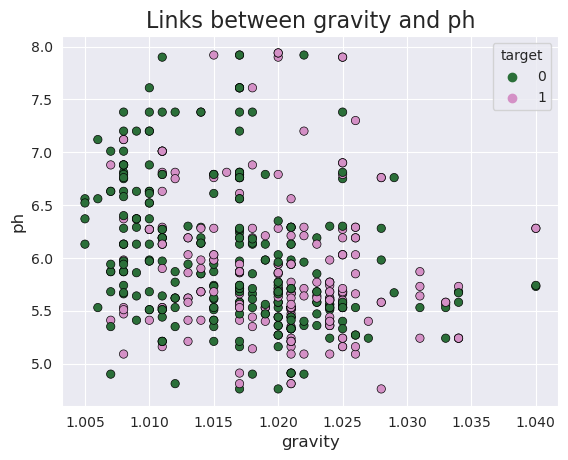

In [5]:
sns.set_style('darkgrid')
plt.title('Links between gravity and ph',size=16)
plt.xlabel('gravity',size=12)
plt.ylabel('ph',size=12)
sns.scatterplot(x='gravity', y='ph', data=train, hue='target', edgecolor='black', palette='cubehelix')
plt.show()

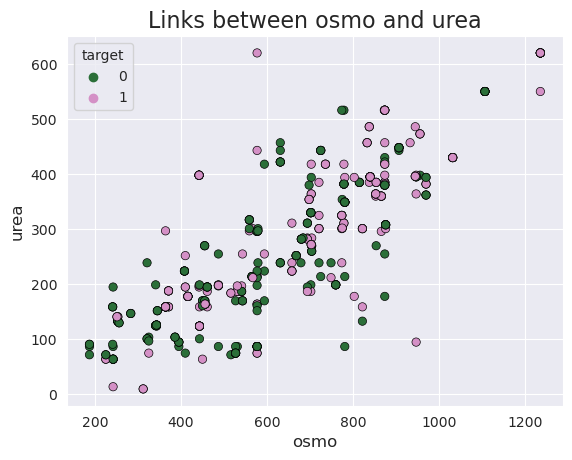

In [6]:
sns.set_style('darkgrid')
plt.title('Links between osmo and urea',size=16)
plt.xlabel('osmo',size=12)
plt.ylabel('urea',size=12)
sns.scatterplot(x='osmo', y='urea', data=train, hue='target', edgecolor='black', palette='cubehelix')
plt.show()

# Correlogram

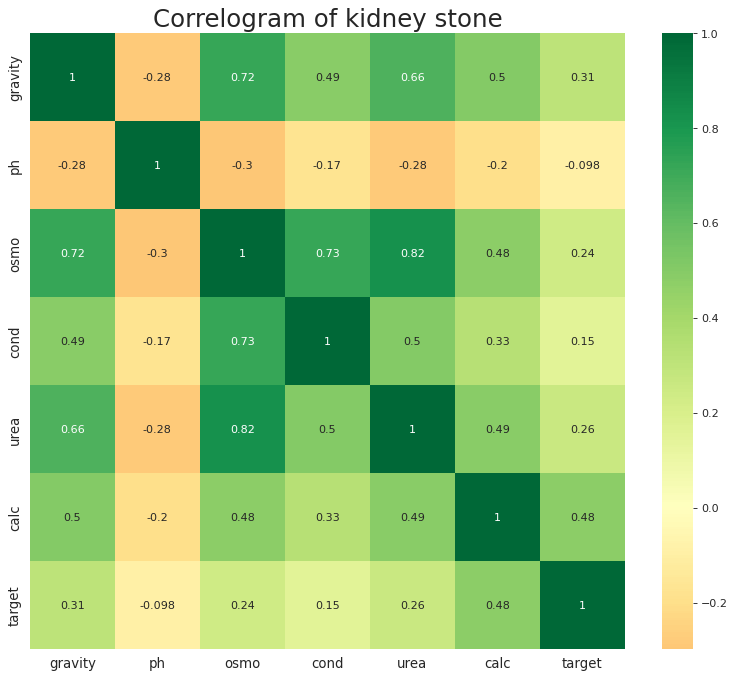

In [7]:
plt.figure(figsize=(12,10), dpi= 80)
sns.heatmap(train.corr(), xticklabels=train.corr().columns, yticklabels=train.corr().columns, cmap='RdYlGn', center=0, annot=True)

# Decorations
plt.title('Correlogram of kidney stone', fontsize=22)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()

# Scatter

<Figure size 800x640 with 0 Axes>

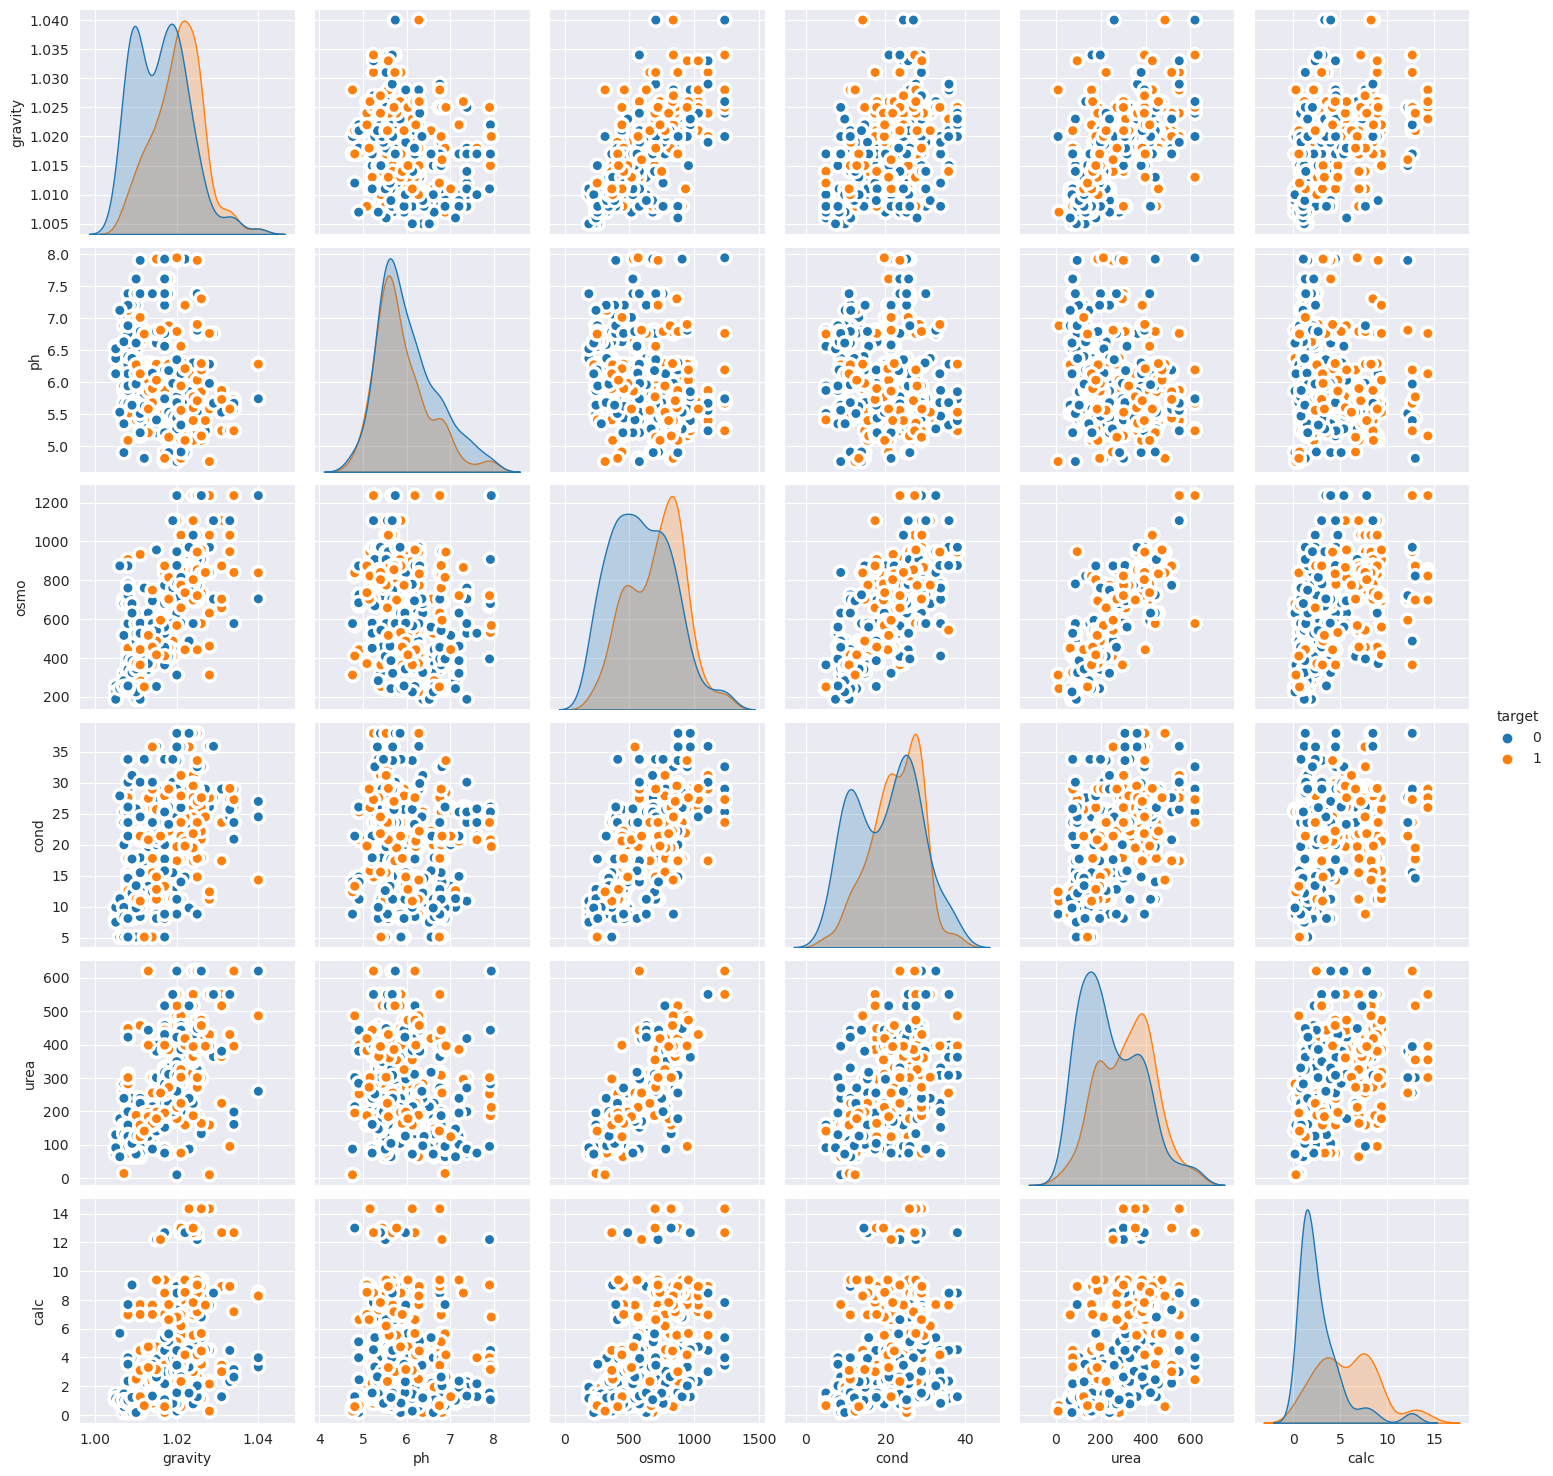

In [8]:
plt.figure(figsize=(10,8), dpi= 80)
sns.pairplot(train, kind="scatter", hue="target", plot_kws=dict(s=80, edgecolor="white", linewidth=2.5))
plt.show()

# Reg

<Figure size 800x640 with 0 Axes>

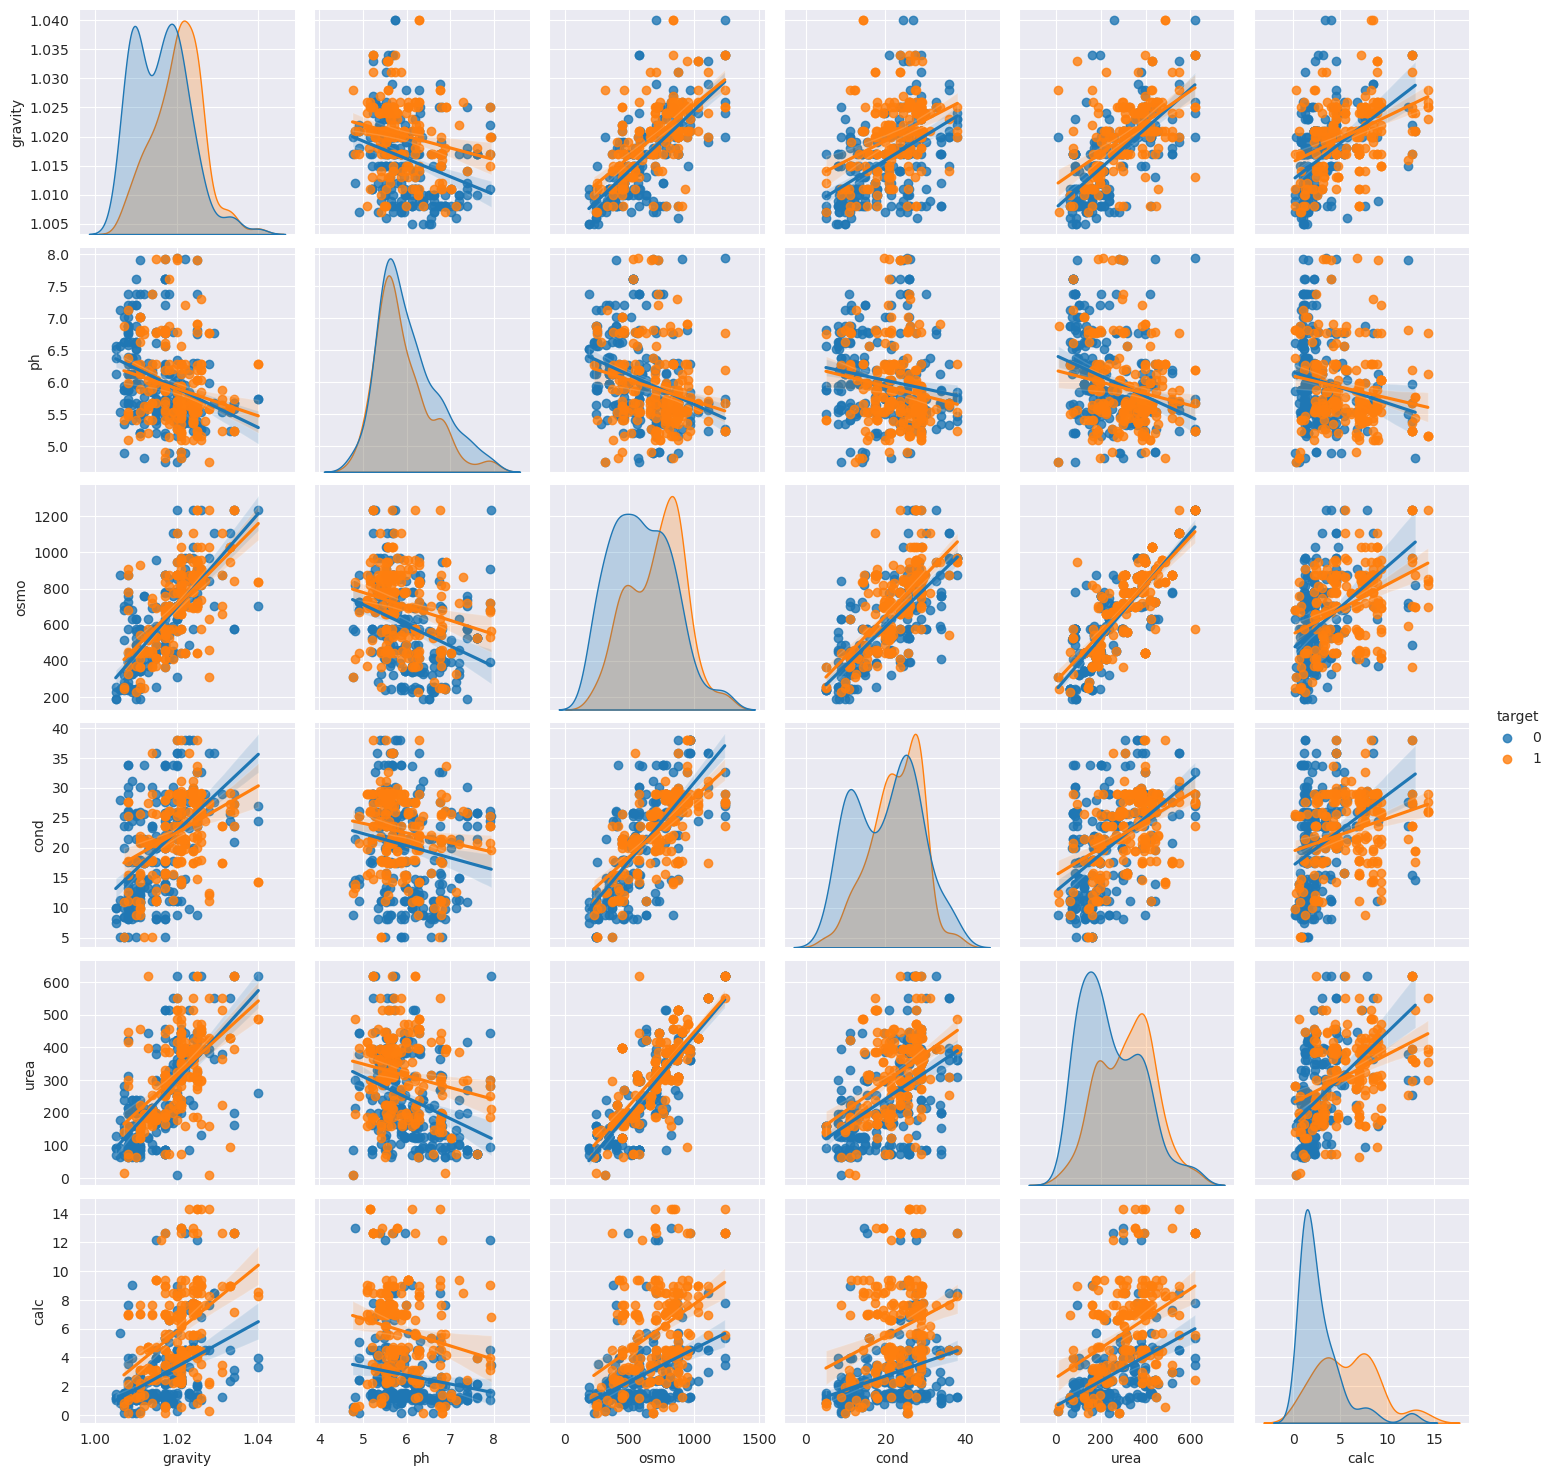

In [9]:
plt.figure(figsize=(10,8), dpi= 80)
sns.pairplot(train, kind="reg", hue="target")
plt.show()

# Outlier

In [10]:
train.columns

Index(['gravity', 'ph', 'osmo', 'cond', 'urea', 'calc', 'target'], dtype='object')

In [11]:
def outlier_removal(data , i):
    q1 = np.quantile(data[i] ,0.25)
    q3 = np.quantile(data[i] , 0.75)
    iqr = q3-q1
    lower_tail = q1 - 1.5*iqr
    upper_tail = q3 + 1.5*iqr
    data.drop(data[data[i]> upper_tail].index , inplace = True)
    data.drop(data[data[i]< lower_tail].index ,inplace =True)
    
outlier_list = ['gravity', 'ph', 'osmo', 'cond', 'urea', 'calc']
for  i in outlier_list:
    outlier_removal(train ,i)

# Data marking

In [12]:
X = train.drop(columns = ['target'],  axis =1)
y = train['target']
X_total = test

# Best features

In [13]:
bestfeatures = SelectKBest(score_func = chi2, k = 'all')
fit = bestfeatures.fit(X, y)
dfscores = pd.DataFrame(fit.scores_)
dfcolumns = pd.DataFrame(X.columns)

featureScores = pd.concat([dfcolumns, dfscores], axis = 1)
featureScores.columns = ['Specs', 'Score']  
print(featureScores.nlargest(10, 'Score')) 

     Specs        Score
2     osmo  2685.343009
4     urea  2305.280189
5     calc   275.565855
3     cond    38.737592
1       ph     0.291568
0  gravity     0.002044


# Aggregate Featrues

In [14]:
class AggFeatureExtractor(BaseEstimator, TransformerMixin):
    
    def __init__(self, group_col, agg_col, agg_func):
        self.group_col = group_col
        self.group_col_name = ''
        for col in group_col:
            self.group_col_name += col
        self.agg_col = agg_col
        self.agg_func = agg_func
        self.agg_df = None
        self.medians = None
        
    def fit(self, X, y=None):
        group_col = self.group_col
        agg_col = self.agg_col
        agg_func = self.agg_func
        
        self.agg_df = X.groupby(group_col)[agg_col].agg(agg_func)
        self.agg_df.columns = [f'{self.group_col_name}_{agg}_{_agg_col}' for _agg_col in agg_col for agg in agg_func]
        self.medians = X[agg_col].median()
        
        return self
    
    def transform(self, X):
        group_col = self.group_col
        agg_col = self.agg_col
        agg_func = self.agg_func
        agg_df = self.agg_df
        medians = self.medians
        
        X_merged = pd.merge(X, agg_df, left_on=group_col, right_index=True, how='left')
        X_merged.fillna(medians, inplace=True)
        X_agg = X_merged.loc[:, [f'{self.group_col_name}_{agg}_{_agg_col}' for _agg_col in agg_col for agg in agg_func]]
        
        return X_agg
    
    def fit_transform(self, X, y=None):
        self.fit(X, y)
        X_agg = self.transform(X)
        return X_agg

In [15]:
class Preprocessor:
    def __init__(self, agg_col, agg_func, group_cols):
        self.agg_col = agg_col
        self.agg_func = agg_func
        self.group_cols = group_cols
        
    def preprocess(self, X, X_total):        
        agg_train, agg_test = [], []
        for group_col in self.group_cols:
            agg_extractor = AggFeatureExtractor(group_col=group_col, agg_col=self.agg_col, agg_func=self.agg_func)
            agg_extractor.fit(pd.concat([X, X_total], axis=0))
            agg_train.append(agg_extractor.transform(X))
            agg_test.append(agg_extractor.transform(X_total))
        X = pd.concat([X] + agg_train, axis=1)
        X_total = pd.concat([X_total] + agg_test, axis=1)
        
        X = X.fillna(0)
        X_total = X_total.fillna(0)
       
        
        return X, X_total   

In [16]:
X.columns

Index(['gravity', 'ph', 'osmo', 'cond', 'urea', 'calc'], dtype='object')

In [17]:
agg_col = ['gravity', 'ph', 'osmo', 'cond', 'urea', 'calc']

agg_func = ['mean', 'std']
group_cols = [['gravity'], ['osmo'], ['urea'], 
              ['gravity', 'osmo'], ['gravity', 'urea'], 
              ['osmo', 'urea'], 
              ['gravity', 'osmo', 'urea']]

pp = Preprocessor(agg_col, agg_func, group_cols)
X, X_total = pp.preprocess(X, X_total)

print(f"X_train shape :{X.shape} , y_train shape :{y.shape}")
print(f"X_test shape :{X_total.shape}")

X_train shape :(468, 90) , y_train shape :(468,)
X_test shape :(276, 90)


# Train test split

In [18]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.45, random_state=42)

# Сlassification Report

In [19]:
def plot_classification_report(classificationReport,
                               title='Classification report',
                               cmap='RdBu'):

    classificationReport = classificationReport.replace('\n\n', '\n')
    classificationReport = classificationReport.replace(' / ', '/')
    lines = classificationReport.split('\n')
    
    classes, plotMat, support, class_names = [], [], [], []
    for line in lines[1 : (len(lines) - 4)]:  # if you don't want avg/total result, then change [1:] into [1:-1]
        t = line.strip().replace(' avg', '-avg').split()
        if len(t) < 2:
            continue
        classes.append(t[0])
        v = [float(x) for x in t[1: len(t) - 1]]
        support.append(int(t[-1]))
        class_names.append(t[0])
        plotMat.append(v)

    plotMat = np.array(plotMat)
    xticklabels = ['Precision', 'Recall', 'F1-score']
    yticklabels = ['{0} ({1})'.format(class_names[idx], sup)
                   for idx, sup in enumerate(support)]
    
    plt.figure(figsize=(10,10))

    plt.imshow(plotMat, interpolation='nearest', cmap=cmap, aspect='auto')
    plt.title(title)
    plt.colorbar()
    plt.xticks(np.arange(3), xticklabels, rotation=45)
    plt.yticks(np.arange(len(classes)), yticklabels)

    upper_thresh = plotMat.min() + (plotMat.max() - plotMat.min()) / 10 * 8
    lower_thresh = plotMat.min() + (plotMat.max() - plotMat.min()) / 10 * 2
    for i, j in itertools.product(range(plotMat.shape[0]), range(plotMat.shape[1])):
        plt.text(j, i, format(plotMat[i, j], '.2f'),
                 horizontalalignment="center",
                 color="white" if (plotMat[i, j] > upper_thresh or plotMat[i, j] < lower_thresh) else "black")

    plt.ylabel('Classes')
    plt.xlabel('Metrics')
    plt.tight_layout()


# Catboost

In [20]:
def objective(trial):
    model = catboost.CatBoostClassifier(
        iterations=trial.suggest_int("iterations", 100, 1000),
        learning_rate=trial.suggest_float("learning_rate", 1e-3, 1e-1, log=True),
        depth=trial.suggest_int("depth", 4, 10),
        l2_leaf_reg=trial.suggest_float("l2_leaf_reg", 1e-8, 100.0, log=True),
        bootstrap_type=trial.suggest_categorical("bootstrap_type", ["Bayesian"]),
        random_strength=trial.suggest_float("random_strength", 1e-8, 10.0, log=True),
        bagging_temperature=trial.suggest_float("bagging_temperature", 0.0, 10.0),
        od_type=trial.suggest_categorical("od_type", ["IncToDec", "Iter"]),
        od_wait=trial.suggest_int("od_wait", 10, 50),
        verbose=False
    )
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    return accuracy


study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=50)

print("Number of finished trials: {}".format(len(study.trials)))

print("Best trial:")
trial = study.best_trial

print("  Value: {}".format(trial.value))

print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

[I 2024-03-24 08:42:54,590] A new study created in memory with name: no-name-d78136d7-d729-4988-b8cd-56ab7770291b
[I 2024-03-24 08:42:59,152] Trial 0 finished with value: 0.6937984496124031 and parameters: {'iterations': 229, 'learning_rate': 0.07078580574866114, 'depth': 9, 'l2_leaf_reg': 0.0001616217020676915, 'bootstrap_type': 'Bayesian', 'random_strength': 2.516116336224797e-08, 'bagging_temperature': 3.6645726981350766, 'od_type': 'IncToDec', 'od_wait': 11}. Best is trial 0 with value: 0.6937984496124031.
[I 2024-03-24 08:43:03,388] Trial 1 finished with value: 0.6782945736434108 and parameters: {'iterations': 451, 'learning_rate': 0.03487716507697696, 'depth': 8, 'l2_leaf_reg': 1.2238450345702767e-05, 'bootstrap_type': 'Bayesian', 'random_strength': 0.3472011688817187, 'bagging_temperature': 0.3499101785767411, 'od_type': 'IncToDec', 'od_wait': 18}. Best is trial 0 with value: 0.6937984496124031.
[I 2024-03-24 08:43:09,452] Trial 2 finished with value: 0.7054263565891473 and para

Number of finished trials: 50
Best trial:
  Value: 0.7364341085271318
  Params: 
    iterations: 859
    learning_rate: 0.0023238916159083584
    depth: 5
    l2_leaf_reg: 0.399591161935039
    bootstrap_type: Bayesian
    random_strength: 0.000941174157836711
    bagging_temperature: 2.712214884700358
    od_type: Iter
    od_wait: 40


              precision    recall  f1-score   support

           0       0.74      0.79      0.76       139
           1       0.73      0.67      0.70       119

    accuracy                           0.74       258
   macro avg       0.74      0.73      0.73       258
weighted avg       0.74      0.74      0.74       258



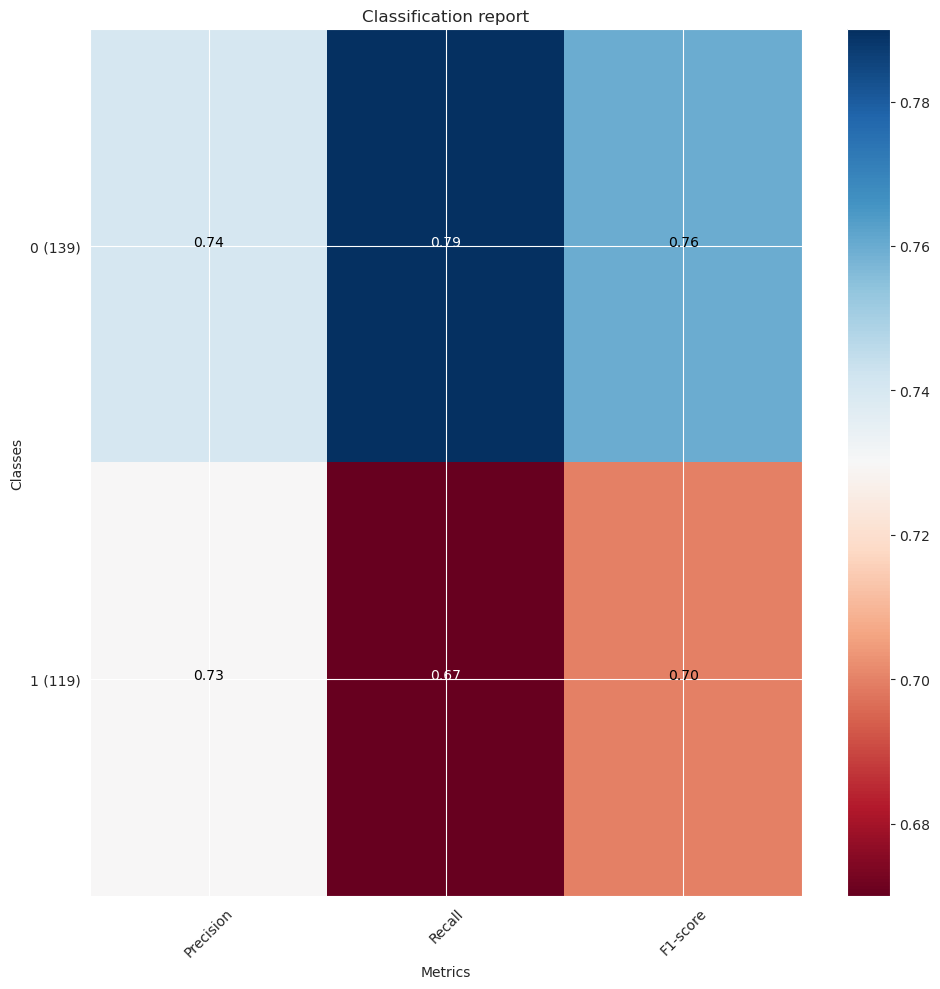

In [21]:
ct_best = study.best_params
model = catboost.CatBoostClassifier(**ct_best, verbose = 0)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
clf =classification_report(y_test, y_pred)
plot_classification_report(clf)
print(clf)

# Light GBM

In [22]:
train_y_label = y_train
valid_y_label = y_test
dtrain = lgb.Dataset(X_train, label=train_y_label)

# FYI: Objective functions can take additional arguments
# (https://optuna.readthedocs.io/en/stable/faq.html#objective-func-additional-args).
def objective(trial):
    param = {
        'objective': 'binary',
        'metric': 'binary_logloss',
        'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
        'lambda_l2': trial.suggest_loguniform('lambda_l2', 1e-8, 10.0),
        'num_leaves': trial.suggest_int('num_leaves', 2, 256),
        'feature_fraction': trial.suggest_uniform('feature_fraction', 0.4, 1.0),
        'bagging_fraction': trial.suggest_uniform('bagging_fraction', 0.4, 1.0),
        'bagging_freq': trial.suggest_int('bagging_freq', 1, 7),
        'min_child_samples': trial.suggest_int('min_child_samples', 5, 100),
        'feature_pre_filter' : False
    }

    gbm = lgb.train(param, dtrain)
    preds = gbm.predict(X_test)
    pred_labels = []
    for i in range(0,len(preds)):
        pred_labels.append(np.argmax(preds[i]))
    accuracy = cal_acc(valid_y_label, pred_labels)
    return accuracy

def cal_acc(true, pred):
    return np.mean(true==pred)

study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=50)

print("Number of finished trials: {}".format(len(study.trials)))

print("Best trial:")
trial = study.best_trial

print("  Value: {}".format(trial.value))

print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

[I 2024-03-24 08:46:02,972] A new study created in memory with name: no-name-497972a5-0202-4735-820e-4e8fd1021804
[I 2024-03-24 08:46:03,056] Trial 0 finished with value: 0.5387596899224806 and parameters: {'lambda_l1': 6.52047956635596e-08, 'lambda_l2': 4.02274381473632, 'num_leaves': 84, 'feature_fraction': 0.8079611019987325, 'bagging_fraction': 0.483436092113454, 'bagging_freq': 5, 'min_child_samples': 57}. Best is trial 0 with value: 0.5387596899224806.
[I 2024-03-24 08:46:03,089] Trial 1 finished with value: 0.5387596899224806 and parameters: {'lambda_l1': 7.520886432556481e-08, 'lambda_l2': 2.765133922000407e-07, 'num_leaves': 81, 'feature_fraction': 0.96889128536403, 'bagging_fraction': 0.9438511033143346, 'bagging_freq': 4, 'min_child_samples': 97}. Best is trial 0 with value: 0.5387596899224806.
[I 2024-03-24 08:46:03,115] Trial 2 finished with value: 0.5387596899224806 and parameters: {'lambda_l1': 3.975065042401503e-06, 'lambda_l2': 1.8538273467510464, 'num_leaves': 107, 'f

[LightGBM] [Info] Number of positive: 90, number of negative: 120
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003210 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3136
[LightGBM] [Info] Number of data points in the train set: 210, number of used features: 78
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.428571 -> initscore=-0.287682
[LightGBM] [Info] Start training from score -0.287682
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [W

[I 2024-03-24 08:46:03,232] Trial 5 finished with value: 0.5387596899224806 and parameters: {'lambda_l1': 0.0121970123402115, 'lambda_l2': 0.0003366911661390721, 'num_leaves': 108, 'feature_fraction': 0.8261591159317903, 'bagging_fraction': 0.823553414091593, 'bagging_freq': 3, 'min_child_samples': 44}. Best is trial 0 with value: 0.5387596899224806.
[I 2024-03-24 08:46:03,272] Trial 6 finished with value: 0.5387596899224806 and parameters: {'lambda_l1': 0.00013399690960879952, 'lambda_l2': 4.66503331481921e-07, 'num_leaves': 160, 'feature_fraction': 0.9497367256069372, 'bagging_fraction': 0.8866030884326952, 'bagging_freq': 6, 'min_child_samples': 53}. Best is trial 0 with value: 0.5387596899224806.
[I 2024-03-24 08:46:03,319] Trial 7 finished with value: 0.5387596899224806 and parameters: {'lambda_l1': 0.004474633616296035, 'lambda_l2': 0.0023349172919755194, 'num_leaves': 117, 'feature_fraction': 0.9077560440289073, 'bagging_fraction': 0.8002265386653067, 'bagging_freq': 2, 'min_chi

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2024-03-24 08:46:03,437] Trial 9 finished with value: 0.5387596899224806 and parameters: {'lambda_l1': 1.5818486079464653e-07, 'lambda_l2': 1.683096730623806, 'num_leaves': 95, 'feature_fraction': 0.9167793834206285, 'bagging_fraction': 0.7548177949390036, 'bagging_freq': 3, 'min_child_samples': 7}. Best is trial 0 with value: 0.5387596899224806.
[I 2024-03-24 08:46:03,516] Trial 10 finished with value: 0.5387596899224806 and parameters: {'lambda_l1': 7.149111875038099, 'lambda_l2': 0.029273657657523863, 'num_leaves': 238, 'feature_fraction': 0.6614633559957962, 'bagging_fraction': 0.4523344480423407, 'bagging_freq': 5, 'min_child_samples': 71}. Best is trial 0 with value: 0.5387596899224806.
[I 2024-03-24 08:46:03,589] Trial 11 finished with value: 0.5387596899224806 and parameters: {'lambda_l1': 2.5411607030410207e-06, 'lambda_l2': 1.6212341840257635e-05, 'num_leaves': 43, 'feature_fraction': 0.8263924062972499, 'bagging_fraction': 0.6424617638709348, 'bagging_freq': 4, 'min_child

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Number of positive: 90, number of negative: 120
[LightGBM] [Warning] Auto-choosing

[I 2024-03-24 08:46:03,682] Trial 12 finished with value: 0.5387596899224806 and parameters: {'lambda_l1': 1.3073362150742776e-08, 'lambda_l2': 6.384769981498079e-06, 'num_leaves': 64, 'feature_fraction': 0.9898093287274156, 'bagging_fraction': 0.6209241240106513, 'bagging_freq': 5, 'min_child_samples': 24}. Best is trial 0 with value: 0.5387596899224806.
[I 2024-03-24 08:46:03,759] Trial 13 finished with value: 0.5387596899224806 and parameters: {'lambda_l1': 1.5112227302460645e-06, 'lambda_l2': 0.04308441667989087, 'num_leaves': 162, 'feature_fraction': 0.8399354159384926, 'bagging_fraction': 0.5311209838804682, 'bagging_freq': 4, 'min_child_samples': 77}. Best is trial 0 with value: 0.5387596899224806.
[I 2024-03-24 08:46:03,834] Trial 14 finished with value: 0.5387596899224806 and parameters: {'lambda_l1': 1.0254939359775201e-08, 'lambda_l2': 1.2778019368499415e-08, 'num_leaves': 63, 'feature_fraction': 0.7447667727398649, 'bagging_fraction': 0.4121613476841054, 'bagging_freq': 7, 

[LightGBM] [Info] Number of positive: 90, number of negative: 120
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000386 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3136
[LightGBM] [Info] Number of data points in the train set: 210, number of used features: 78
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.428571 -> initscore=-0.287682
[LightGBM] [Info] Start training from score -0.287682
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, b

[I 2024-03-24 08:46:03,920] Trial 15 finished with value: 0.5387596899224806 and parameters: {'lambda_l1': 2.5912504126900834e-05, 'lambda_l2': 4.280494493051857e-07, 'num_leaves': 9, 'feature_fraction': 0.8831723529272739, 'bagging_fraction': 0.6866315951330086, 'bagging_freq': 6, 'min_child_samples': 67}. Best is trial 0 with value: 0.5387596899224806.
[I 2024-03-24 08:46:04,006] Trial 16 finished with value: 0.5387596899224806 and parameters: {'lambda_l1': 2.508024786715766e-07, 'lambda_l2': 0.05650086129213938, 'num_leaves': 166, 'feature_fraction': 0.9988712597826033, 'bagging_fraction': 0.5596778541037901, 'bagging_freq': 3, 'min_child_samples': 35}. Best is trial 0 with value: 0.5387596899224806.


[LightGBM] [Info] Number of positive: 90, number of negative: 120
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000511 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3136
[LightGBM] [Info] Number of data points in the train set: 210, number of used features: 78
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.428571 -> initscore=-0.287682
[LightGBM] [Info] Start training from score -0.287682
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, b

[I 2024-03-24 08:46:04,167] Trial 17 finished with value: 0.5387596899224806 and parameters: {'lambda_l1': 3.518826108155669e-07, 'lambda_l2': 0.0024531931576245534, 'num_leaves': 70, 'feature_fraction': 0.9021280361447492, 'bagging_fraction': 0.9869677626872135, 'bagging_freq': 6, 'min_child_samples': 9}. Best is trial 0 with value: 0.5387596899224806.
[I 2024-03-24 08:46:04,269] Trial 18 finished with value: 0.5387596899224806 and parameters: {'lambda_l1': 1.435078020930669e-05, 'lambda_l2': 5.000053639268466, 'num_leaves': 195, 'feature_fraction': 0.7628326218609673, 'bagging_fraction': 0.7139891376074526, 'bagging_freq': 4, 'min_child_samples': 88}. Best is trial 0 with value: 0.5387596899224806.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2024-03-24 08:46:04,359] Trial 19 finished with value: 0.5387596899224806 and parameters: {'lambda_l1': 9.622303479464784e-08, 'lambda_l2': 0.3549674044821485, 'num_leaves': 82, 'feature_fraction': 0.8584673940238053, 'bagging_fraction': 0.49012448078880233, 'bagging_freq': 5, 'min_child_samples': 63}. Best is trial 0 with value: 0.5387596899224806.
[I 2024-03-24 08:46:04,442] Trial 20 finished with value: 0.5387596899224806 and parameters: {'lambda_l1': 8.498269871279498e-07, 'lambda_l2': 7.858344727903336, 'num_leaves': 38, 'feature_fraction': 0.9390453333771253, 'bagging_fraction': 0.5658036708529397, 'bagging_freq': 2, 'min_child_samples': 77}. Best is trial 0 with value: 0.5387596899224806.


[LightGBM] [Info] Number of positive: 90, number of negative: 120
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000480 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3136
[LightGBM] [Info] Number of data points in the train set: 210, number of used features: 78
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.428571 -> initscore=-0.287682
[LightGBM] [Info] Start training from score -0.287682
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that m

[I 2024-03-24 08:46:04,542] Trial 21 finished with value: 0.5387596899224806 and parameters: {'lambda_l1': 8.139868612628394e-06, 'lambda_l2': 7.714260920581067, 'num_leaves': 140, 'feature_fraction': 0.43588053191610504, 'bagging_fraction': 0.902673627445663, 'bagging_freq': 1, 'min_child_samples': 89}. Best is trial 0 with value: 0.5387596899224806.
[I 2024-03-24 08:46:04,650] Trial 22 finished with value: 0.5387596899224806 and parameters: {'lambda_l1': 2.1586048462949872e-06, 'lambda_l2': 0.17641803725582958, 'num_leaves': 136, 'feature_fraction': 0.40805362081074015, 'bagging_fraction': 0.8647415234469834, 'bagging_freq': 1, 'min_child_samples': 77}. Best is trial 0 with value: 0.5387596899224806.
[I 2024-03-24 08:46:04,756] Trial 23 finished with value: 0.5387596899224806 and parameters: {'lambda_l1': 5.326489141332611e-08, 'lambda_l2': 1.5802557060879547, 'num_leaves': 83, 'feature_fraction': 0.5696822366151953, 'bagging_fraction': 0.7518534842119659, 'bagging_freq': 4, 'min_chi

[LightGBM] [Info] Number of positive: 90, number of negative: 120
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000396 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3136
[LightGBM] [Info] Number of data points in the train set: 210, number of used features: 78
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.428571 -> initscore=-0.287682
[LightGBM] [Info] Start training from score -0.287682
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, b

[I 2024-03-24 08:46:04,864] Trial 24 finished with value: 0.5387596899224806 and parameters: {'lambda_l1': 2.892094745768403e-07, 'lambda_l2': 0.4366180218481023, 'num_leaves': 48, 'feature_fraction': 0.4874277278769728, 'bagging_fraction': 0.9340268197593866, 'bagging_freq': 1, 'min_child_samples': 84}. Best is trial 0 with value: 0.5387596899224806.
[I 2024-03-24 08:46:04,965] Trial 25 finished with value: 0.5387596899224806 and parameters: {'lambda_l1': 5.129684472339908e-08, 'lambda_l2': 0.011731036742351996, 'num_leaves': 95, 'feature_fraction': 0.5704696649400343, 'bagging_fraction': 0.7842909057689357, 'bagging_freq': 3, 'min_child_samples': 100}. Best is trial 0 with value: 0.5387596899224806.


[LightGBM] [Info] Number of positive: 90, number of negative: 120
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000448 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3136
[LightGBM] [Info] Number of data points in the train set: 210, number of used features: 78
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.428571 -> initscore=-0.287682
[LightGBM] [Info] Start training from score -0.287682
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, b

[I 2024-03-24 08:46:05,072] Trial 26 finished with value: 0.5387596899224806 and parameters: {'lambda_l1': 5.774713295523169e-07, 'lambda_l2': 0.19989421261968054, 'num_leaves': 137, 'feature_fraction': 0.7931755082590157, 'bagging_fraction': 0.8612049354176504, 'bagging_freq': 6, 'min_child_samples': 81}. Best is trial 0 with value: 0.5387596899224806.
[I 2024-03-24 08:46:05,180] Trial 27 finished with value: 0.5387596899224806 and parameters: {'lambda_l1': 7.712086740079834e-06, 'lambda_l2': 1.7337666021509948, 'num_leaves': 212, 'feature_fraction': 0.724446395209509, 'bagging_fraction': 0.40671813690810327, 'bagging_freq': 2, 'min_child_samples': 44}. Best is trial 0 with value: 0.5387596899224806.


[LightGBM] [Info] Total Bins 3136
[LightGBM] [Info] Number of data points in the train set: 210, number of used features: 78
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.428571 -> initscore=-0.287682
[LightGBM] [Info] Start training from score -0.287682
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best ga

[I 2024-03-24 08:46:05,284] Trial 28 finished with value: 0.5387596899224806 and parameters: {'lambda_l1': 3.4296092348474954e-08, 'lambda_l2': 0.12612742216922201, 'num_leaves': 97, 'feature_fraction': 0.6970250397141808, 'bagging_fraction': 0.9530017068828028, 'bagging_freq': 5, 'min_child_samples': 69}. Best is trial 0 with value: 0.5387596899224806.
[I 2024-03-24 08:46:05,376] Trial 29 finished with value: 0.5387596899224806 and parameters: {'lambda_l1': 8.527248054704042e-07, 'lambda_l2': 6.451104645525392e-08, 'num_leaves': 128, 'feature_fraction': 0.6107963354020837, 'bagging_fraction': 0.8366685880251934, 'bagging_freq': 7, 'min_child_samples': 91}. Best is trial 0 with value: 0.5387596899224806.


[LightGBM] [Info] Number of positive: 90, number of negative: 120
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000470 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3136
[LightGBM] [Info] Number of data points in the train set: 210, number of used features: 78
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.428571 -> initscore=-0.287682
[LightGBM] [Info] Start training from score -0.287682
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, b

[I 2024-03-24 08:46:05,498] Trial 30 finished with value: 0.5387596899224806 and parameters: {'lambda_l1': 6.268712297434972e-08, 'lambda_l2': 9.753250403087176, 'num_leaves': 77, 'feature_fraction': 0.7918211699125256, 'bagging_fraction': 0.8489144311421026, 'bagging_freq': 4, 'min_child_samples': 18}. Best is trial 0 with value: 0.5387596899224806.
[I 2024-03-24 08:46:05,589] Trial 31 finished with value: 0.5387596899224806 and parameters: {'lambda_l1': 1.4557675572321374e-07, 'lambda_l2': 1.322914671510447e-08, 'num_leaves': 110, 'feature_fraction': 0.686751129969684, 'bagging_fraction': 0.9034540251931434, 'bagging_freq': 7, 'min_child_samples': 83}. Best is trial 0 with value: 0.5387596899224806.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2024-03-24 08:46:05,684] Trial 32 finished with value: 0.5387596899224806 and parameters: {'lambda_l1': 6.364011921172458e-05, 'lambda_l2': 6.391424998355156e-05, 'num_leaves': 121, 'feature_fraction': 0.4952921893052184, 'bagging_fraction': 0.7952469639705889, 'bagging_freq': 7, 'min_child_samples': 46}. Best is trial 0 with value: 0.5387596899224806.
[I 2024-03-24 08:46:05,773] Trial 33 finished with value: 0.5387596899224806 and parameters: {'lambda_l1': 0.0003609303672041629, 'lambda_l2': 4.2116231406336195e-07, 'num_leaves': 152, 'feature_fraction': 0.8648904760738639, 'bagging_fraction': 0.8263908084700382, 'bagging_freq': 6, 'min_child_samples': 94}. Best is trial 0 with value: 0.5387596899224806.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2024-03-24 08:46:05,876] Trial 34 finished with value: 0.5387596899224806 and parameters: {'lambda_l1': 0.0006460492429854231, 'lambda_l2': 2.23217698554145e-06, 'num_leaves': 103, 'feature_fraction': 0.7866160878927683, 'bagging_fraction': 0.8960308269436987, 'bagging_freq': 2, 'min_child_samples': 56}. Best is trial 0 with value: 0.5387596899224806.
[I 2024-03-24 08:46:05,974] Trial 35 finished with value: 0.5387596899224806 and parameters: {'lambda_l1': 4.169636827082976e-06, 'lambda_l2': 1.3233776056591767e-07, 'num_leaves': 180, 'feature_fraction': 0.9540990788561705, 'bagging_fraction': 0.9469526968951396, 'bagging_freq': 6, 'min_child_samples': 87}. Best is trial 0 with value: 0.5387596899224806.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Number of positive: 90, number of negative: 120
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000442 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3136
[LightGBM] [Info] Number of data points in the train set: 210, number of used features: 78
[LightGBM] [Info] [binary:BoostFromScore]: p

[I 2024-03-24 08:46:06,072] Trial 36 finished with value: 0.5387596899224806 and parameters: {'lambda_l1': 0.002231912513693126, 'lambda_l2': 0.0006008326963238653, 'num_leaves': 54, 'feature_fraction': 0.8168547605409544, 'bagging_fraction': 0.8041325846209341, 'bagging_freq': 3, 'min_child_samples': 61}. Best is trial 0 with value: 0.5387596899224806.
[I 2024-03-24 08:46:06,167] Trial 37 finished with value: 0.5387596899224806 and parameters: {'lambda_l1': 5.235804265715438e-05, 'lambda_l2': 0.00012715293620601842, 'num_leaves': 113, 'feature_fraction': 0.7236287664765498, 'bagging_fraction': 0.8679102093046711, 'bagging_freq': 5, 'min_child_samples': 73}. Best is trial 0 with value: 0.5387596899224806.
[I 2024-03-24 08:46:06,268] Trial 38 finished with value: 0.5387596899224806 and parameters: {'lambda_l1': 0.019523095359429064, 'lambda_l2': 5.5052121979368635e-08, 'num_leaves': 86, 'feature_fraction': 0.6482607665826791, 'bagging_fraction': 0.7572105730573163, 'bagging_freq': 3, 'm

[LightGBM] [Info] Number of positive: 90, number of negative: 120
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000562 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3136
[LightGBM] [Info] Number of data points in the train set: 210, number of used features: 78
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.428571 -> initscore=-0.287682
[LightGBM] [Info] Start training from score -0.287682
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, b

[I 2024-03-24 08:46:06,367] Trial 39 finished with value: 0.5387596899224806 and parameters: {'lambda_l1': 2.9708967872355263e-08, 'lambda_l2': 1.8849849290724887e-06, 'num_leaves': 26, 'feature_fraction': 0.9205828129855413, 'bagging_fraction': 0.8237122744822563, 'bagging_freq': 7, 'min_child_samples': 51}. Best is trial 0 with value: 0.5387596899224806.
[I 2024-03-24 08:46:06,457] Trial 40 finished with value: 0.5387596899224806 and parameters: {'lambda_l1': 1.946661732026506e-07, 'lambda_l2': 0.8989388059301643, 'num_leaves': 121, 'feature_fraction': 0.9677665501320177, 'bagging_fraction': 0.9980594193627, 'bagging_freq': 4, 'min_child_samples': 95}. Best is trial 0 with value: 0.5387596899224806.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2024-03-24 08:46:06,564] Trial 41 finished with value: 0.5387596899224806 and parameters: {'lambda_l1': 1.1758031335590632e-08, 'lambda_l2': 0.010462018745192024, 'num_leaves': 109, 'feature_fraction': 0.842882244622792, 'bagging_fraction': 0.9164965511338603, 'bagging_freq': 1, 'min_child_samples': 52}. Best is trial 0 with value: 0.5387596899224806.
[I 2024-03-24 08:46:06,670] Trial 42 finished with value: 0.5387596899224806 and parameters: {'lambda_l1': 1.1684516252155838e-07, 'lambda_l2': 0.0009209480840163684, 'num_leaves': 92, 'feature_fraction': 0.8843389387463088, 'bagging_fraction': 0.9550753815950696, 'bagging_freq': 2, 'min_child_samples': 38}. Best is trial 0 with value: 0.5387596899224806.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2024-03-24 08:46:06,768] Trial 43 finished with value: 0.5387596899224806 and parameters: {'lambda_l1': 1.171944743425481e-06, 'lambda_l2': 1.1545711200067693e-05, 'num_leaves': 256, 'feature_fraction': 0.7629513831145295, 'bagging_fraction': 0.8822759450445309, 'bagging_freq': 1, 'min_child_samples': 66}. Best is trial 0 with value: 0.5387596899224806.
[I 2024-03-24 08:46:06,872] Trial 44 finished with value: 0.5387596899224806 and parameters: {'lambda_l1': 2.7296971711352732e-08, 'lambda_l2': 5.99447741016725e-05, 'num_leaves': 149, 'feature_fraction': 0.9300158677891361, 'bagging_fraction': 0.9720309903193908, 'bagging_freq': 2, 'min_child_samples': 49}. Best is trial 0 with value: 0.5387596899224806.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2024-03-24 08:46:06,973] Trial 45 finished with value: 0.5387596899224806 and parameters: {'lambda_l1': 5.250585096328329e-07, 'lambda_l2': 0.00029672615311567496, 'num_leaves': 65, 'feature_fraction': 0.8950236718087752, 'bagging_fraction': 0.9240957429264157, 'bagging_freq': 5, 'min_child_samples': 60}. Best is trial 0 with value: 0.5387596899224806.
[I 2024-03-24 08:46:07,080] Trial 46 finished with value: 0.5387596899224806 and parameters: {'lambda_l1': 2.7425478265810956e-06, 'lambda_l2': 3.3592202187505706, 'num_leaves': 75, 'feature_fraction': 0.8087012875207803, 'bagging_fraction': 0.878942489067247, 'bagging_freq': 2, 'min_child_samples': 39}. Best is trial 0 with value: 0.5387596899224806.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2024-03-24 08:46:07,193] Trial 47 finished with value: 0.5387596899224806 and parameters: {'lambda_l1': 1.1653310365715441e-07, 'lambda_l2': 2.0820147209168426e-05, 'num_leaves': 124, 'feature_fraction': 0.8287584637364641, 'bagging_fraction': 0.8394666155711905, 'bagging_freq': 1, 'min_child_samples': 28}. Best is trial 0 with value: 0.5387596899224806.
[I 2024-03-24 08:46:07,292] Trial 48 finished with value: 0.5387596899224806 and parameters: {'lambda_l1': 1.3293738418100292e-08, 'lambda_l2': 0.8488729882286503, 'num_leaves': 104, 'feature_fraction': 0.9874951892609465, 'bagging_fraction': 0.6887290963500164, 'bagging_freq': 6, 'min_child_samples': 73}. Best is trial 0 with value: 0.5387596899224806.


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000586 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3136
[LightGBM] [Info] Number of data points in the train set: 210, number of used features: 78
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.428571 -> initscore=-0.287682
[LightGBM] [Info] Start training from score -0.287682
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positiv

[I 2024-03-24 08:46:07,396] Trial 49 finished with value: 0.5387596899224806 and parameters: {'lambda_l1': 3.698182198157638e-07, 'lambda_l2': 0.0026656973102395214, 'num_leaves': 61, 'feature_fraction': 0.8718924773104456, 'bagging_fraction': 0.9720226800372225, 'bagging_freq': 3, 'min_child_samples': 55}. Best is trial 0 with value: 0.5387596899224806.


[LightGBM] [Info] Number of positive: 90, number of negative: 120
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000544 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3136
[LightGBM] [Info] Number of data points in the train set: 210, number of used features: 78
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.428571 -> initscore=-0.287682
[LightGBM] [Info] Start training from score -0.287682
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, b

[LightGBM] [Warning] lambda_l1 is set=6.52047956635596e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=6.52047956635596e-08
[LightGBM] [Warning] feature_fraction is set=0.8079611019987325, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8079611019987325
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] lambda_l2 is set=4.02274381473632, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.02274381473632
[LightGBM] [Warning] bagging_fraction is set=0.483436092113454, subsample=1.0 will be ignored. Current value: bagging_fraction=0.483436092113454
              precision    recall  f1-score   support

           0       0.71      0.70      0.71       139
           1       0.66      0.67      0.66       119

    accuracy                           0.69       258
   macro avg       0.68      0.69      0.68       258
weighted avg       0.69      0.69      0.69       258


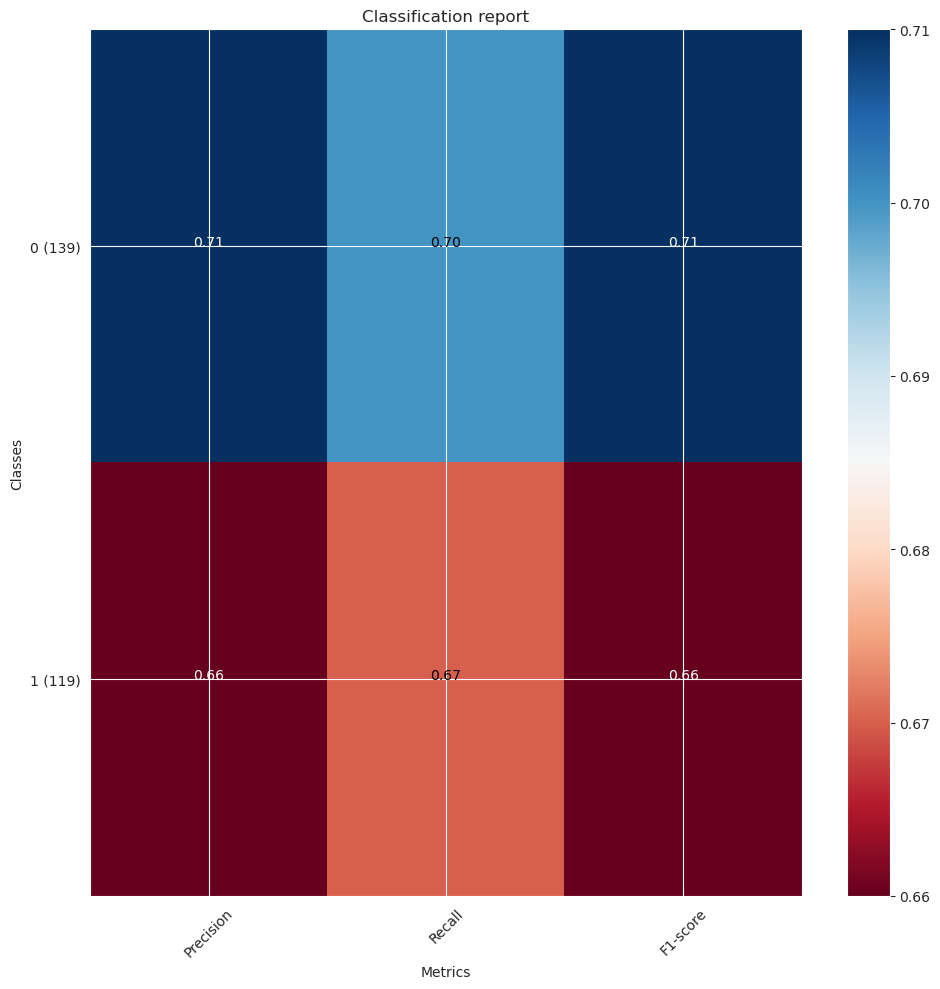

In [23]:
lgb_best = study.best_params
model = lgb.LGBMClassifier(**lgb_best)
model.fit(X_train, train_y_label)
y_pred = model.predict(X_test)
clf =classification_report(valid_y_label, y_pred)
plot_classification_report(clf)
print(clf)

# XGB

In [24]:
train_y_label = y_train
valid_y_label = y_test
train_x_tr, valid_x_es, train_y_tr, valid_y_es = train_test_split(X_train, train_y_label, test_size=0.2)

dtrain = xgb.DMatrix(train_x_tr, label=train_y_tr)
dtest = xgb.DMatrix(X_test, label=valid_y_label)

def objective(trial):

    param = {
        "verbosity": 0,
        "objective": "multi:softmax",
        "num_class": 5,
        # use exact for small dataset.
        "tree_method": "exact",
        # defines booster, gblinear for linear functions.
        "booster": trial.suggest_categorical("booster", ["gbtree", "gblinear", "dart"]),
        # L2 regularization weight.
        "lambda": trial.suggest_float("lambda", 1e-8, 1.0, log=True),
        # L1 regularization weight.
        "alpha": trial.suggest_float("alpha", 1e-8, 1.0, log=True),
        # sampling ratio for training data.
        "subsample": trial.suggest_float("subsample", 0.2, 1.0),
        # sampling according to each tree.
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.2, 1.0),
        "early_stopping_rounds":200,
        "evals":([valid_x_es,valid_y_es])
    }

    if param["booster"] in ["gbtree", "dart"]:
        # maximum depth of the tree, signifies complexity of the tree.
        param["max_depth"] = trial.suggest_int("max_depth", 3, 9, step=2)
        # minimum child weight, larger the term more conservative the tree.
        param["min_child_weight"] = trial.suggest_int("min_child_weight", 2, 10)
        param["eta"] = trial.suggest_float("eta", 1e-8, 1.0, log=True)
        # defines how selective algorithm is.
        param["gamma"] = trial.suggest_float("gamma", 1e-8, 1.0, log=True)
        param["grow_policy"] = trial.suggest_categorical("grow_policy", ["depthwise", "lossguide"])

    if param["booster"] == "dart":
        param["sample_type"] = trial.suggest_categorical("sample_type", ["uniform", "weighted"])
        param["normalize_type"] = trial.suggest_categorical("normalize_type", ["tree", "forest"])
        param["rate_drop"] = trial.suggest_float("rate_drop", 1e-8, 1.0, log=True)
        param["skip_drop"] = trial.suggest_float("skip_drop", 1e-8, 1.0, log=True)

    bst = xgb.train(param, dtrain)
    preds = bst.predict(dtest)
    pred_labels = np.rint(preds)
    accuracy = sklearn.metrics.accuracy_score(valid_y_label, pred_labels)
    return accuracy

study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=50, timeout=600)

print("Number of finished trials: {}".format(len(study.trials)))

print("Best trial:")
trial = study.best_trial

print("  Value: {}".format(trial.value))

print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

[I 2024-03-24 08:46:09,078] A new study created in memory with name: no-name-21c28548-08c0-4fe9-bcc8-85023b63cb48
[I 2024-03-24 08:46:09,178] Trial 0 finished with value: 0.7093023255813954 and parameters: {'booster': 'gblinear', 'lambda': 2.9971983697987008e-05, 'alpha': 0.017420243567494564, 'subsample': 0.5050260680394363, 'colsample_bytree': 0.9145917037849347}. Best is trial 0 with value: 0.7093023255813954.
[I 2024-03-24 08:46:09,318] Trial 1 finished with value: 0.7286821705426356 and parameters: {'booster': 'dart', 'lambda': 0.0018344763950970844, 'alpha': 6.25350611373558e-08, 'subsample': 0.939936370472177, 'colsample_bytree': 0.5748560971785437, 'max_depth': 9, 'min_child_weight': 8, 'eta': 1.6066256033429262e-08, 'gamma': 4.268242653457591e-05, 'grow_policy': 'lossguide', 'sample_type': 'uniform', 'normalize_type': 'forest', 'rate_drop': 4.066466824660391e-08, 'skip_drop': 0.00013655302437147357}. Best is trial 1 with value: 0.7286821705426356.
[I 2024-03-24 08:46:09,458] T

Number of finished trials: 50
Best trial:
  Value: 0.7364341085271318
  Params: 
    booster: dart
    lambda: 9.723443212554953e-08
    alpha: 0.14884694036856622
    subsample: 0.7775751065673164
    colsample_bytree: 0.5623010879202371
    max_depth: 3
    min_child_weight: 7
    eta: 0.33265667702828566
    gamma: 0.0014241509785463838
    grow_policy: depthwise
    sample_type: uniform
    normalize_type: tree
    rate_drop: 0.7518447129778418
    skip_drop: 8.768320100661877e-05


              precision    recall  f1-score   support

           0       0.72      0.78      0.75       139
           1       0.72      0.66      0.68       119

    accuracy                           0.72       258
   macro avg       0.72      0.72      0.72       258
weighted avg       0.72      0.72      0.72       258



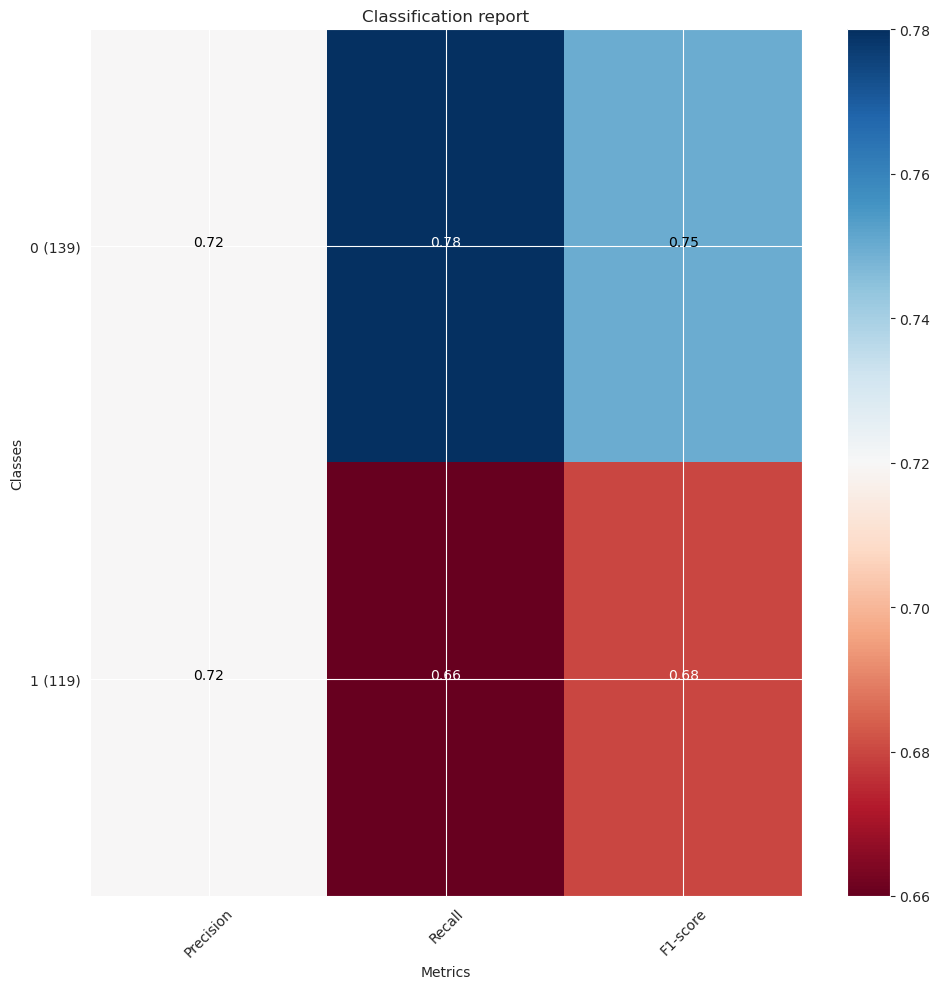

In [25]:
xgb_best = study.best_params
model = xgb.XGBClassifier(**xgb_best)
model.fit(train_x_tr,train_y_tr,eval_set=[(valid_x_es,valid_y_es)],early_stopping_rounds=200,verbose=False)
y_pred = model.predict(X_test)
clf =classification_report(valid_y_label, y_pred)
plot_classification_report(clf)
print(clf)

# Compare ensemble

In [26]:
classifier1 = catboost.CatBoostClassifier(**ct_best, verbose = 0)
classifier2 = lgb.LGBMClassifier(**lgb_best)
classifier3 = xgb.XGBClassifier(**xgb_best)
classifier4 = RandomForestClassifier()
classifier5 = CalibratedClassifierCV(classifier1, cv=KFold(n_splits=15))
classifier6 = CalibratedClassifierCV(classifier3, cv=KFold(n_splits=15))
classifier7 = catboost.CatBoostClassifier(verbose = 0)
classifier8 = AdaBoostClassifier()
classifier9 = KNeighborsClassifier()
classifier10 = GaussianProcessClassifier()

sclf = StackingCVClassifier(classifiers = [classifier1, classifier2, classifier3, classifier4, 
                                           classifier5, classifier6, classifier7, classifier8,
                                          classifier9, classifier10],
                            shuffle = False,
                            use_probas = True,
                            cv = KFold(n_splits=20),
                            meta_classifier = catboost.CatBoostClassifier(**ct_best, verbose = 0))

In [27]:
classifiers = {"cat": classifier1,
               "lgb": classifier2,
               "xgb": classifier3,
               'rf' : classifier4,
               'calib':classifier5,
               'calib2':classifier6,
               'bagg':classifier7,
               'xgb2':classifier8,
               'lgb1':classifier9,
               'gas': classifier10,
               "Stack": sclf}

In [28]:
for key in classifiers:
    # Get classifier
    classifier = classifiers[key]
    
    # Fit classifier
    classifier.fit(X_train, y_train)
        
    # Save fitted classifier
    classifiers[key] = classifier

[LightGBM] [Warning] lambda_l1 is set=6.52047956635596e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=6.52047956635596e-08
[LightGBM] [Warning] feature_fraction is set=0.8079611019987325, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8079611019987325
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] lambda_l2 is set=4.02274381473632, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.02274381473632
[LightGBM] [Warning] bagging_fraction is set=0.483436092113454, subsample=1.0 will be ignored. Current value: bagging_fraction=0.483436092113454
[LightGBM] [Warning] lambda_l1 is set=6.52047956635596e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=6.52047956635596e-08
[LightGBM] [Warning] feature_fraction is set=0.8079611019987325, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8079611019987325
[LightGBM] [Warning] bagging_freq i

In [29]:
results = pd.DataFrame()
for key in classifiers:
    # Make prediction on test set
    y_pred = classifiers[key].predict_proba(X_test)[:,1]
    
    # Save results in pandas dataframe object
    results[f"{key}"] = y_pred

# Add the test set to the results object
results['Target'] = y_test.index.duplicated()

In [30]:
results

cat       lgb       xgb    rf     calib    calib2      bagg  \
0    0.199221  0.318663  0.285484  0.30  0.263949  0.251011  0.211463   
1    0.623850  0.367873  0.384125  0.66  0.620613  0.328604  0.769003   
2    0.718526  0.638021  0.641840  0.78  0.687225  0.642252  0.789532   
3    0.827867  0.703098  0.773627  0.72  0.730562  0.731164  0.738664   
4    0.356991  0.731736  0.629239  0.30  0.396824  0.637578  0.266209   
..        ...       ...       ...   ...       ...       ...       ...   
253  0.616625  0.731714  0.629967  0.66  0.594880  0.632110  0.639083   
254  0.849802  0.746620  0.780366  0.89  0.761289  0.734755  0.889762   
255  0.522290  0.757721  0.630005  0.66  0.524130  0.611201  0.585043   
256  0.660511  0.780702  0.755830  0.88  0.671908  0.725272  0.756119   
257  0.183272  0.288202  0.192774  0.07  0.251365  0.245260  0.096902   

         xgb2  lgb1       gas     Stack  Target  
0    0.491309   0.4  0.500000  0.326281   False  
1    0.504768   0.4  0.500000  0.277792   False  
2    0.547291   0.6  0.500000  0.702676   False  
3    0.548440   0.4  0.500000  0.810351   False  
4    0.470800   0.6  0.499676  0.619089   False  
..        ...   ...       ...       ...     ...  
253  0.508526   0.6  0.500000  0.728996   False  
254  0.520994   0.4  0.500000  0.730091   False  
255  0.489628   0.8  0.500000  0.820365   False  
256  0.496167   0.6  0.500005  0.653594   False  
257  0.473792   0.2  0.500000  0.242150    True  

[258 rows x 12 columns]

# Visualizing Results

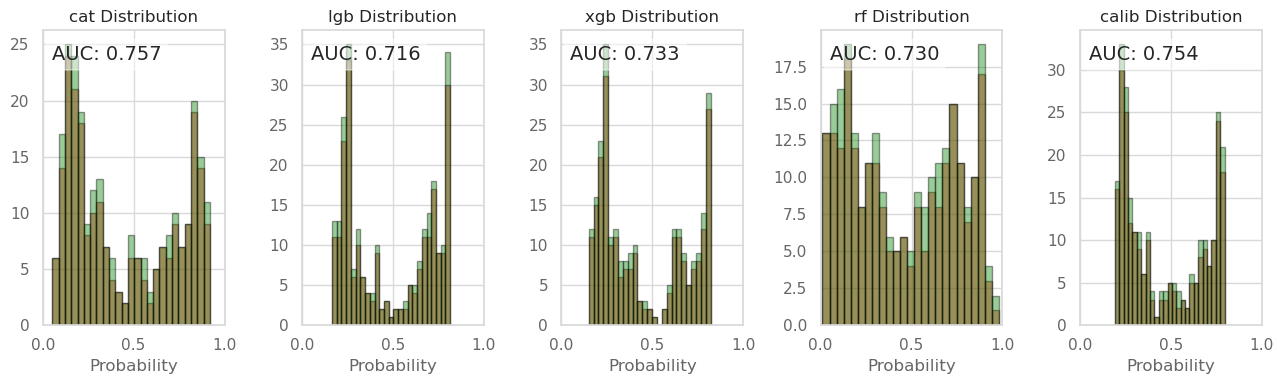

In [31]:
sns.set(font_scale = 1)
sns.set_style({"axes.facecolor": "1.0", "axes.edgecolor": "0.85", "grid.color": "0.85",
               "grid.linestyle": "-", 'axes.labelcolor': '0.4', "xtick.color": "0.4",
               'ytick.color': '0.4'})

# Plot
f, ax = plt.subplots(figsize=(13, 4), nrows=1, ncols = 5)

for key, counter in zip(classifiers, range(5)):
    # Get predictions
    y_pred = results[key]
    
    # Get AUC
    auc = metrics.roc_auc_score(y_test, y_pred)
    textstr = f"AUC: {auc:.3f}"

    # Plot false distribution
    false_pred = results[results["Target"] == 0]
    sns.distplot(false_pred[key], hist=True, kde=False, 
                 bins=int(25), color = 'red',
                 hist_kws={'edgecolor':'black'}, ax = ax[counter])
    
    # Plot true distribution
    true_pred = results[results["Target"] == 1]
    sns.distplot(results[key], hist=True, kde=False, 
                 bins=int(25), color = 'green',
                 hist_kws={'edgecolor':'black'}, ax = ax[counter])
    
    
    # These are matplotlib.patch.Patch properties
    props = dict(boxstyle='round', facecolor='white', alpha=0.5)
    
    # Place a text box in upper left in axes coords
    ax[counter].text(0.05, 0.95, textstr, transform=ax[counter].transAxes, fontsize=14,
                    verticalalignment = "top", bbox=props)
    
    # Set axis limits and labels
    ax[counter].set_title(f"{key} Distribution")
    ax[counter].set_xlim(0,1)
    ax[counter].set_xlabel("Probability")

# Tight layout
plt.tight_layout()

# Save Figure
plt.savefig("Probability Distribution for each Classifier.png", dpi = 1080)

# Make predict

In [32]:
results = pd.DataFrame()
for key in classifiers:
    # Make prediction on test set
    y_pred = classifiers[key].predict_proba(X_total)[:,1]

# Submit

In [33]:
sub = pd.read_csv('/kaggle/input/playground-series-s3e12/sample_submission.csv')
sub['target'] = y_pred
sub

id    target
0    414  0.410161
1    415  0.733464
2    416  0.649217
3    417  0.185523
4    418  0.297743
..   ...       ...
271  685  0.701131
272  686  0.264073
273  687  0.772637
274  688  0.284481
275  689  0.353817

[276 rows x 2 columns]

In [34]:
sub.to_csv('submission.csv', index=False)